# export this to other file formats

These files are symbolically linked such that their source is the
version-controlled directory, but they can be exported from the local
directory where the analysis happens

Due to this difference in directory structure, anyone else using these
scripts will have to make sure the locations of their data are specified
correctly in the [set working
directories](id:480a4f07-3de0-4588-95ee-2d8d98683f41) scetion.

## convert to jupyter notebook

### using pandoc

this looks nice but it's just a big markdown block

``` bash
pandoc 6.11_analysis.org -o parametersensitivity_analysis_pandoc.ipynb
```

### using orgparse

this is the only way that makes runnable python cells, though lots of
formatting doesn't work

``` python
import orgparse
import nbformat as nbf
import re
import base64

def parse_results(results_block):
    """
    Parse the #+RESULTS: block to extract outputs.
    """
    outputs = []
    lines = results_block.strip().split("\n")

    for line in lines:
        if line.strip().startswith(": "):
            outputs.append(nbf.v4.new_output(output_type="stream", name="stdout", text=line[2:].strip() + "\n"))
        elif re.match(r"\[\[.*\.(png|jpg|jpeg|gif)\]\]", line.strip()):
            image_path = re.search(r"\[\[(.*\.(png|jpg|jpeg|gif))\]\]", line.strip()).group(1)
            try:
                with open(image_path, "rb") as f:
                    image_data = base64.b64encode(f.read()).decode("utf-8")
                outputs.append(nbf.v4.new_output(
                    output_type="display_data",
                    data={"image/png": image_data},
                    metadata={}
                ))
            except FileNotFoundError:
                print(f"Warning: Image file not found: {image_path}")
    return outputs

def convert_org_links_to_markdown(text):
    """
    Convert Org mode links to Markdown links.
    """
    text = re.sub(r"\[\[([^\]]+)\]\[([^\]]+)\]\]", r"[\2](\1)", text)
    text = re.sub(r"\[\[([^\]]+)\]\]", r"[\1](\1)", text)
    return text

def org_to_ipynb(org_file, ipynb_file):
    org = orgparse.load(org_file)
    nb = nbf.v4.new_notebook()
    cells = []

    for node in org[1:]:
        if ":noexport:" in node.tags or (node.heading and ":noexport:" in node.heading.lower()):
            continue

        if node.heading:
            heading_level = "#" * node.level
            cells.append(nbf.v4.new_markdown_cell(f"{heading_level} {node.heading}"))

        in_code_block = False
        in_results_block = False
        code_lines = []
        markdown_lines = []
        results_block = ""

        for line in node.body.split("\n"):
            if line.strip().startswith("#+BEGIN_SRC python"):
                in_code_block = True
                if markdown_lines:
                    markdown_text = convert_org_links_to_markdown("\n".join(markdown_lines)).strip()
                    if markdown_text:
                        cells.append(nbf.v4.new_markdown_cell(markdown_text))
                    markdown_lines = []
                continue
            elif line.strip().startswith("#+END_SRC"):
                in_code_block = False
                if code_lines:
                    code_cell = nbf.v4.new_code_cell("\n".join(code_lines))
                    cells.append(code_cell)
                    code_lines = []
                continue
            elif line.strip().startswith("#+RESULTS:"):
                in_results_block = True
                continue
            elif in_results_block and line.strip() == ":end:":
                in_results_block = False
                if results_block.strip():
                    outputs = parse_results(results_block)
                    if outputs and cells:
                        cells[-1].outputs = outputs
                results_block = ""
            elif in_code_block:
                code_lines.append(line)
            elif in_results_block:
                results_block += line + "\n"
            else:
                markdown_lines.append(convert_org_links_to_markdown(line))

        markdown_text = convert_org_links_to_markdown("\n".join(markdown_lines)).strip()
        if markdown_text:
            cells.append(nbf.v4.new_markdown_cell(markdown_text))

    nb.cells = cells
    with open(ipynb_file, "w") as f:
        nbf.write(nb, f)

# Convert your Org file
org_to_ipynb("6.11_analysis.org",
             "parametersensitivity_analysis_orgparse.ipynb")
```

``` commonlisp
(org-babel-tangle)
```

``` bash
python convert_org_to_ipynb.py
```

## export to org document

``` commonlisp
(org-org-export-to-org)
```

## export to markdown document

``` commonlisp
(org-md-export-to-markdown)
```

# figure generation index

| figure | panel | link                                                  |
|--------|-------|-------------------------------------------------------|
| S2     | E     | [line plots](id:07413486-9b24-4374-a154-96cef8d1f299) |
| S2     | E     | [line plots](id:07413486-9b24-4374-a154-96cef8d1f299) |
| S2     | E     | [line plots](id:07413486-9b24-4374-a154-96cef8d1f299) |
| S2     | E     | [line plots](id:07413486-9b24-4374-a154-96cef8d1f299) |

# configuration

## set global variables

``` python
#timestep = 5e-5
report = 'no'
replace_movies = 'no'
save_figures = 'yes'
save_dataframes = 'yes'
```

## load and configure libraries

``` python
import os
import sys
from tabulate import tabulate
import math
import numpy as np
import pandas as pd
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # nicer plotting
from decimal import Decimal
import matplotlib.colors as mplcolors
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from matplotlib.cm import ScalarMappable
from scipy.stats import binned_statistic_2d
from scipy import stats
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import textwrap
from decimal import Decimal
from scipy.stats import binned_statistic_2d
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt  # plotting
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
plt.style.use('seaborn-v0_8-colorblind') # set plot style
plt.cool()                          # heatmap color scheme
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=mcolors.TABLEAU_COLORS)
%matplotlib inline

import seaborn as sns  # nicer plotting
sns.set_style('whitegrid')  # set plot style

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=[6,5]) # default figure width, height

now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date
```

## set working directories

``` python
#machine = 'peeks'
machine = 'ltpbukem'

if machine == 'ltpbukem':
    drive_dir = '/home/maxferrin/google_drive/'

if machine == 'bizon':
    drive_dir = '/media/bizon/DATA/MFerrin/insync/'

if machine == 'peeks':
    drive_dir = '/scratch/ferrin/unison_peeks/'

if machine == 'drumroom':
    drive_dir = '/Users/max/google_drive/'

if machine == 'mbp':
    drive_dir = '/Users/maxferrin/google_drive/'

if machine == 'sobarky':
    drive_dir = '/Users/dblab/google_drive/'


working_dir = os.path.join(drive_dir, 'grad_school/db_lab/code/analysis/20230610_6.11_parameter_sensitivity/')
cytosim_dir = os.path.join(drive_dir, 'grad_school/db_lab/code/cytosim_dblab/', machine)

if machine == 'peeks':
    working_dir = '/run/media/ferrin/Volume/max/analysis/20230610_6.11_parameter_sensitivity/'
    cytosim_dir = '/home/ferrin/cytosim/'

dataframes_dir = os.path.join(working_dir,'dataframes/')

os.chdir(working_dir)

if os.path.isdir('figures') == False:
    os.mkdir('figures')
if os.path.isdir('dataframes') == False:
    os.mkdir('dataframes')
```

## load custom functions

``` python
# add parent folder to path
sys.path.insert(1, '../')
from cytosim_analysis import cytosim_analysis_functions as caf

# reload custom library
from importlib import reload
reload(sys.modules['cytosim_analysis'])
```

# find directories that have outputs or config files

``` python
output_dirs, config_dirs = caf.find_directories()
print(output_dirs, config_dirs)
```

``` example
['6.11.9_output', '6.11.8_output', '6.11.4_output', '6.11.1_output', '6.11.2_output', '6.11.7_output', '6.11.3_output'] ['6.11.2', '6.11.7', '6.11.3', '6.11.8', '6.11.1', '6.11.9', '6.11.4']
```

# report simulations

``` python
caf.report_sims(working_dir, output_dirs, cytosim_dir, report)
```

# read in reports

-   not enough memory to do all at once!
-   just fiber forces alone requires too much memory

``` python
reports = [
    'solid',
    # 'single_hip1r',
    'single_membrane_myosin'#,
    # 'fiber_cluster',
    # 'fiber_forces',
    # 'fiber_tensions',
    # 'fiber_ends'
    ]

#reports = ['solid']
#reports = ['fiber_ends']

solid_allruns_allparams, properties_allruns_allparams, \
configs_allruns_allparams, single_hip1r_allruns_allparams, \
single_membrane_myosin_allruns_allparams, fiber_forces_allruns_allparams, \
fiber_clusters_allruns_allparams, fiber_tensions_allruns_allparams, \
fiber_ends_allruns_allparams, rundirs_allparams, total_runs = \
caf.open_reports(reports, working_dir, output_dirs, config_dirs,
cytosim_dir, replace_movies)

if save_dataframes == 'yes':
    pd.DataFrame.from_dict(rundirs_allparams, orient = 'index').to_pickle(dataframes_dir+'rundirs_allparams.pkl')
```

``` example
finished reporting 6.11.9_output
finished reporting 6.11.8_output
finished reporting 6.11.4_output
finished reporting 6.11.1_output
finished reporting 6.11.2_output
finished reporting 6.11.7_output
finished reporting 6.11.3_output
```

# read simulation properties

## put all properties and configs into dataframes

``` python
properties_allparams, config_allparams = caf.props_configs(
    output_dirs, rundirs_allparams_df,
    properties_allruns_allparams, configs_allruns_allparams)
```

## filter for properties that vary among simulations

``` python
cols = list(properties_allparams)
nunique = properties_allparams.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
properties_unique = properties_allparams.drop(cols_to_drop, axis=1)
properties_unique = properties_unique.drop(labels='internalize_random_seed',axis=1)
properties_unique.head()
```

|                                                           | myosin<sub>binding</sub> | myosin<sub>unbinding</sub> | myosin<sub>stallforce</sub> | membrane<sub>myosinstiffness</sub> |
|-----------------------------------------------------------|--------------------------|----------------------------|-----------------------------|------------------------------------|
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)') | 3, 0.004                 | 67.6, -3.67                | 100                         | 100                                |
| ('6.11.9<sub>output</sub>', 'run0004<sub>0002</sub>')     | 3, 0.004                 | 67.6, -3.67                | 10000                       | 100                                |
| ('6.11.9<sub>output</sub>', 'run0007<sub>0003</sub>')     | 3, 0.004                 | 67.6, 0                    | 10                          | 100                                |
| ('6.11.9<sub>output</sub>', 'run0011<sub>0003</sub>')     | 3, 0.004                 | 67.6, 0                    | 1e+06                       | 100                                |
| ('6.11.9<sub>output</sub>', 'run0011<sub>0002</sub>')     | 3, 0.004                 | 67.6, 0                    | 1e+06                       | 100                                |

``` python
cols = list(config_allparams)
nunique = config_allparams.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
config_unique = config_allparams.drop(cols_to_drop, axis=1)
config_unique = config_unique.drop(['membrane_myosin_position'], axis=1)
config_unique = config_unique.astype('float')
config_unique.head()
```

|                                                           | myosin<sub>bindingrate</sub> | myosin<sub>bindingrange</sub> | myosin<sub>unbindingforce</sub> | myosin<sub>stallforce</sub> | membrane<sub>myosinstiffness</sub> | membrane<sub>myosinzoffset</sub> |
|-----------------------------------------------------------|------------------------------|-------------------------------|---------------------------------|-----------------------------|------------------------------------|----------------------------------|
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)') | 3                            | 0.004                         | -3.67                           | 100                         | 100                                | 0.008                            |
| ('6.11.9<sub>output</sub>', 'run0004<sub>0002</sub>')     | 3                            | 0.004                         | -3.67                           | 10000                       | 100                                | 0.008                            |
| ('6.11.9<sub>output</sub>', 'run0007<sub>0003</sub>')     | 3                            | 0.004                         | 0                               | 10                          | 100                                | 0.008                            |
| ('6.11.9<sub>output</sub>', 'run0011<sub>0003</sub>')     | 3                            | 0.004                         | 0                               | 1e+06                       | 100                                | 0.008                            |
| ('6.11.9<sub>output</sub>', 'run0011<sub>0002</sub>')     | 3                            | 0.004                         | 0                               | 1e+06                       | 100                                | 0.008                            |

# parse results into dataframe

## solid positions

``` python
solid_allparams = caf.solid_positions(output_dirs, rundirs_allparams_df, solid_allruns_allparams)

if save_dataframes == 'yes':
    solid_allparams.to_pickle(dataframes_dir+'solid_allparams.pkl')

solid_allparams.head()
```

``` example
finished parsing 6.11.9_output
finished parsing 6.11.8_output
finished parsing 6.11.4_output
finished parsing 6.11.1_output
finished parsing 6.11.2_output
finished parsing 6.11.7_output
finished parsing 6.11.3_output
```

|                                                                   | xpos        | ypos         | zpos      | rpos       | internalization |
|-------------------------------------------------------------------|-------------|--------------|-----------|------------|-----------------|
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)', 0.1, 1) | -0.0010335  | -8.14752e-05 | -0.395141 | 0.00103671 | 0.004859        |
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)', 0.2, 1) | -0.00310684 | -0.00010208  | -0.390416 | 0.00310852 | 0.009584        |
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)', 0.3, 1) | -0.00202646 | 0.000248301  | -0.389811 | 0.00204162 | 0.010189        |
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)', 0.4, 1) | -0.00277034 | 0.000786084  | -0.388449 | 0.00287971 | 0.011551        |
| ('6.11.9<sub>output</sub>', 'run0002<sub>0003</sub> (1)', 0.5, 1) | -0.00266495 | 0.000313034  | -0.388158 | 0.00268327 | 0.011842        |

## all hip1r

``` python
hip1r_allparams = caf.all_hip1r(output_dirs, rundirs_allparams, single_hip1r_allruns_allparams)

hip1r_allparams.head()
```

## all myosin

``` python
membrane_myosin_allparams = caf.all_myosin(output_dirs, rundirs_allparams, single_membrane_myosin_allruns_allparams)

membrane_myosin_allparams.head()
```

``` example
[0;31m---------------------------------------------------------------------------[0m
[0;31mNameError[0m                                 Traceback (most recent call last)
Cell [0;32mIn[38], line 1[0m
[0;32m----> 1[0m membrane_myosin_allparams [38;5;241m=[39m caf[38;5;241m.[39mall_myosin(output_dirs, [43mrundirs_allparams[49m, single_membrane_myosin_allruns_allparams)
[1;32m      3[0m membrane_myosin_allparams[38;5;241m.[39mhead()

[0;31mNameError[0m: name 'rundirs_allparams' is not defined
```

## fiber forces

``` python
forces_allparams = caf.get_fiber_forces(output_dirs, rundirs_allparams, fiber_forces_allruns_allparams)

forces_allparams.head()
```

## fiber ends

``` python
ends_allparams = caf.get_fiber_ends(output_dirs, rundirs_allparams, fiber_ends_allruns_allparams)

ends_allparams.head()
```

## merge positions with run properties/configs

### solid

``` python
solid_properties = pd.merge(properties_unique.reset_index(), solid_allparams.reset_index(),
                            on=['param_sweep', 'run'], how='outer').set_index(['param_sweep', 'run'])
property_groups = list(properties_unique)
solid_property_groups = solid_properties.groupby(property_groups)
groups = property_groups + ['time']
grouped = solid_properties.groupby(groups)
means = grouped['internalization'].mean()
stds = grouped['internalization'].std()
```

``` python
solid_config = pd.merge(config_unique.reset_index(), solid_allparams.reset_index(),
                        on=['param_sweep', 'run'], how='outer').set_index(['param_sweep', 'run'])
config_groups = list(config_unique)
solid_config_groups = solid_config.groupby(config_groups)
groups = config_groups + ['time']
grouped = solid_config.groupby(groups)
means = grouped['internalization'].mean()
stds = grouped['internalization'].std()
means.head()
```

``` example
myosin_binding_range  myosin_unbinding_force  myosin_stall_force  membrane_myosin_zoffset  time
0.0                   -3.67                   1000000.0           0.008                    0.1     0.002250
                                                                                           0.2     0.002859
                                                                                           0.3     0.003538
                                                                                           0.4     0.003025
                                                                                           0.5     0.003910
Name: internalization, dtype: float64
```

``` python
config_groups = list(config_unique)
sweep_groups = config_groups + ['param_sweep']
solid_sweep_groups = solid_config.groupby(sweep_groups)
groups_sweep = sweep_groups + ['time']
grouped_sweep = solid_config.groupby(groups_sweep)
sweep_means = grouped_sweep['internalization'].mean()
sweep_stds = grouped_sweep['internalization'].std()

sweep_means.head()
```

``` example
myosin_binding_range  myosin_unbinding_force  myosin_stall_force  membrane_myosin_zoffset  param_sweep    time
0.0                   -3.67                   1000000.0           0.008                    6.11.7_output  0.1     0.002250
                                                                                                          0.2     0.002859
                                                                                                          0.3     0.003538
                                                                                                          0.4     0.003025
                                                                                                          0.5     0.003910
Name: internalization, dtype: float64
```

### myosin

``` python
membrane_myosin_config = pd.merge(config_unique.reset_index(), membrane_myosin_allparams.reset_index(),
                        on=['param_sweep', 'run'], how='outer').set_index(['param_sweep', 'run'])
membrane_myosin_grouped = membrane_myosin_config.groupby(groups)
membrane_myosin_zpos_means = membrane_myosin_grouped['zpos'].mean()
membrane_myosin_zpos_stds = membrane_myosin_grouped['zpos'].std()
membrane_myosin_zpos_means.head()
```

``` example
[0;31m---------------------------------------------------------------------------[0m
[0;31mNameError[0m                                 Traceback (most recent call last)
Cell [0;32mIn[44], line 1[0m
[0;32m----> 1[0m membrane_myosin_config [38;5;241m=[39m pd[38;5;241m.[39mmerge([43mconfig_unique[49m[38;5;241m.[39mreset_index(), membrane_myosin_allparams[38;5;241m.[39mreset_index(),
[1;32m      2[0m                         on[38;5;241m=[39m[[38;5;124m'[39m[38;5;124mparam_sweep[39m[38;5;124m'[39m, [38;5;124m'[39m[38;5;124mrun[39m[38;5;124m'[39m], how[38;5;241m=[39m[38;5;124m'[39m[38;5;124mouter[39m[38;5;124m'[39m)[38;5;241m.[39mset_index([[38;5;124m'[39m[38;5;124mparam_sweep[39m[38;5;124m'[39m, [38;5;124m'[39m[38;5;124mrun[39m[38;5;124m'[39m])
[1;32m      3[0m membrane_myosin_grouped [38;5;241m=[39m membrane_myosin_config[38;5;241m.[39mgroupby(groups)
[1;32m      4[0m membrane_myosin_zpos_means [38;5;241m=[39m membrane_myosin_grouped[[38;5;124m'[39m[38;5;124mzpos[39m[38;5;124m'[39m][38;5;241m.[39mmean()

[0;31mNameError[0m: name 'config_unique' is not defined
```

## write dataframes to file

``` python
if save_dataframes == 'yes':
    membrane_myosin_allparams.to_pickle(dataframes_dir+'membrane_myosin_allparams.pkl')
    means.to_pickle(dataframes_dir+'means.pkl')
    stds.to_pickle(dataframes_dir+'stds.pkl')
    sweep_means.to_pickle(dataframes_dir+'sweep_means.pkl')
    sweep_stds.to_pickle(dataframes_dir+'sweep_stds.pkl')
    pd.DataFrame.from_dict(rundirs_allparams, orient = 'index').to_pickle(dataframes_dir+'rundirs_allparams.pkl')
    properties_allparams.to_pickle(dataframes_dir+'properties_allparams.pkl')
    properties_unique.to_pickle(dataframes_dir+'properties_unique.pkl')
```

# load in previously parsed dataframes

``` python
solid_allparams = pd.read_pickle(dataframes_dir+'solid_allparams.pkl')
membrane_myosin_allparams = pd.read_pickle(dataframes_dir+'membrane_myosin_allparams.pkl')
means = pd.read_pickle(dataframes_dir+'means.pkl')
stds = pd.read_pickle(dataframes_dir+'stds.pkl')
sweep_means = pd.read_pickle(dataframes_dir+'sweep_means.pkl')
sweep_stds = pd.read_pickle(dataframes_dir+'sweep_stds.pkl')
rundirs_allparams_df = pd.read_pickle(dataframes_dir+'rundirs_allparams.pkl')
rundirs_allparams_df.fillna(value='empty', inplace=True)
properties_allparams = pd.read_pickle(dataframes_dir+'properties_allparams.pkl')
properties_unique = pd.read_pickle(dataframes_dir+'properties_unique.pkl')
percentiles = pd.read_pickle(dataframes_dir+'percentiles.pkl')
property_groups = list(properties_unique)
```

``` python
total_runs = len(solid_allparams.groupby(['param_sweep','run']).count())
solid_allparams.head()
```

# Analyze 95 percentile

``` python
percentiles = caf.get_percentiles(output_dirs, rundirs_allparams_df, solid_allparams, properties_allparams)

if save_dataframes == 'yes':
    percentiles.to_pickle(dataframes_dir+'percentiles.pkl')
percentiles.head()
```

# Analyze actin density

## total actin at final timepoint

``` python
actin_endpoints = caf.get_actin_endpoints(output_dirs, rundirs_allparams_df, forces_allparams)
actin_endpoints.head()
```

# plot results

## internalization

### all runs on separate plots

``` python
num_plots = total_runs

width = 6
if width > num_plots:
    width = 1
height = int(math.ceil(float(num_plots)/float(width)))

max_int = solid_allparams['internalization'].max()*1000

# plt.figure(figsize=(4*width,3*height)) #width, height
fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, figsize=(4*width,5*height))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
fig.text(0.5, 0, 'time (s)', ha='center', size=24)
fig.text(0, 0.5, 'internalization (nm)', va='center', rotation='vertical', size=24)

plot_no = 0

for output_dir in output_dirs:
    rundirs = rundirs_allparams[output_dir]
    for run in rundirs:

        df = solid_allparams.loc[output_dir].loc[run]
        x = df.reset_index()['time']
        y = df['internalization']*1000
        props = properties_allparams.loc[output_dir].loc[run]
        viscosity = props['internalize.cym_viscosity']
        hip1r_off = props['strongbinder_unbinding'].split(',')[0]

        plot_no += 1

        plt.subplot(height,width,plot_no) #height, width
        plt.plot(x,y)
        plt.xlim(right = 15)
        plt.ylim(top = max_int)
        # plt.xlabel('time (s)')
        # plt.ylabel('internalization (nm)')

        title = output_dir+'\n'+run+'\n'
        for prop in property_groups:
            title += prop + ' = ' + str(props[prop]) + '\n'

        # for prop, value in zip(config_groups, name):
        #     title += prop + ' = ' + str(value) + '\n'


        plt.title(title)

plt.tight_layout()

if save_figures == 'yes':
  plt.savefig(working_dir+'figures/'+pref+'_solid_zpos-vs-time_all.png')
```

``` example
/tmp/ipykernel_31531/3988983614.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(height,width,plot_no) #height, width
```

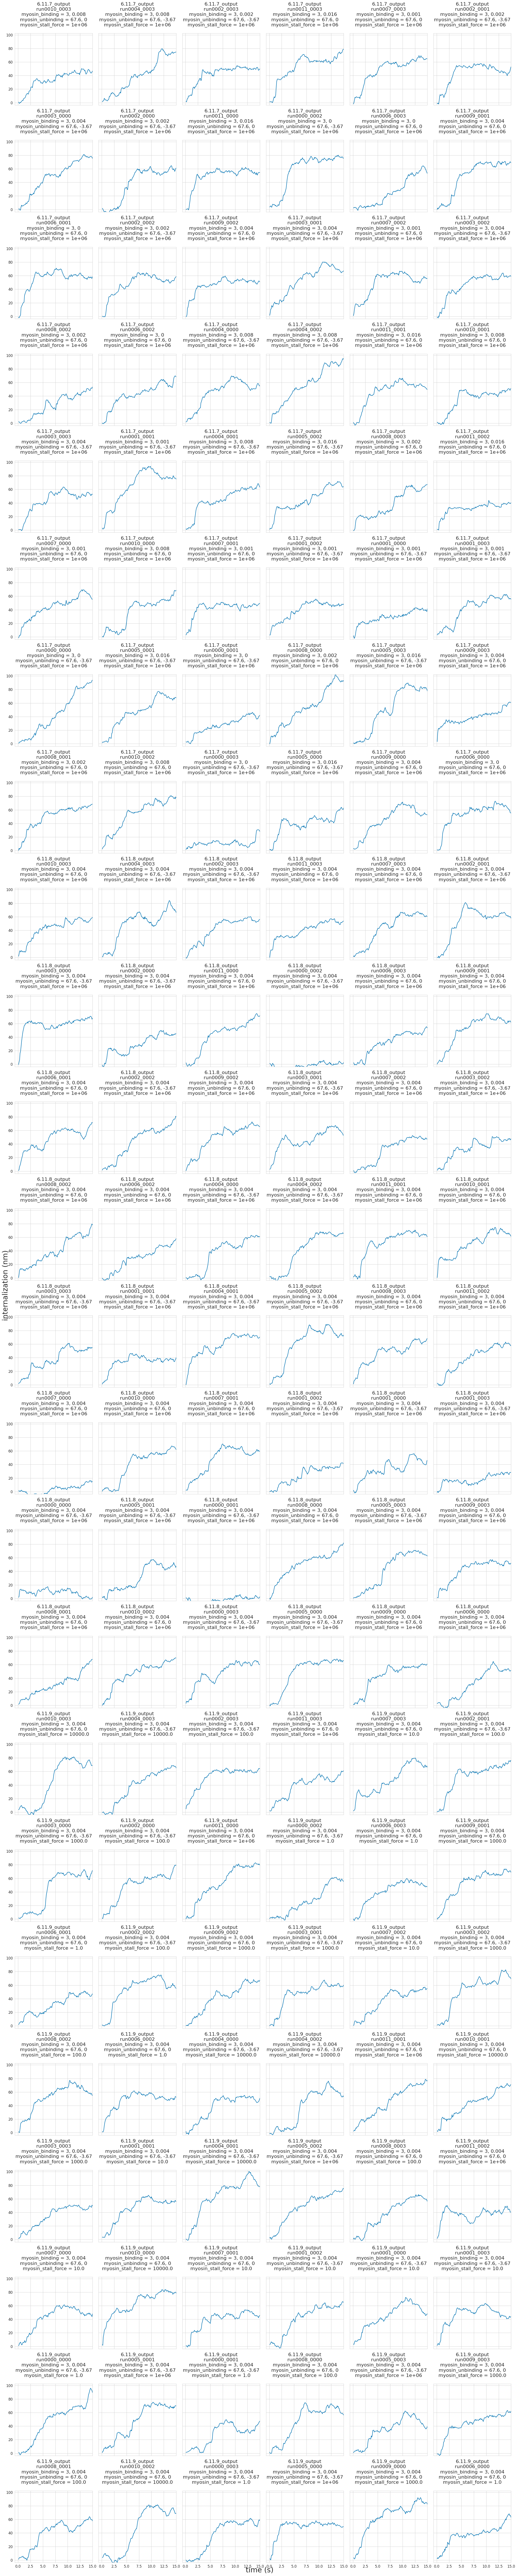

### means of runs with same properties

``` python
# num_plots = len(solid_property_groups)
num_plots = len(solid_config_groups)

width = 6
if width > num_plots:
    width = 1
height = int(math.ceil(float(num_plots)/float(width)))

fig = plt.figure()
fig.set_size_inches(4*width,4*height)

commonaxis = plt.axes(frameon=False)
commonaxis.set_xticks([])
commonaxis.set_yticks([])
commonaxis.yaxis.labelpad = 40 # move the labels a bit away from panels
commonaxis.xaxis.labelpad = 40 # move the labels a bit away from panels
commonaxis.set( xlabel = 'time (s)' )
commonaxis.set( ylabel = 'internalization (nm)' )

plot_no = 1
plot_max = np.max(means + stds)*1000
plot_min = np.min(means - stds)*1000

for name, group in solid_config_groups:
    x = means.loc[name].reset_index()['time']
    y = means.loc[name]*1000
    std = stds.loc[name]*1000

    ax = fig.add_subplot(height, width, plot_no)
    ax.errorbar(x,y,std)
    ax.set_xlim(right = 15)
    ax.set_ylim(bottom = plot_min, top = plot_max)

    title = ''
    for prop, value in zip(config_groups, name):
        title += prop + ' = ' + str(round(value,3)) + '\n'

    ax.set_title(title)
    # ax2[plot_row, plot_col].set_title(title)

    print(plot_no)

    plot_no += 1

plt.tight_layout()

if save_figures == 'yes':
    plt.savefig(working_dir+'figures/'+pref+'_mean_solid_zpos-vs-time_all.png')
```

``` example
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
```

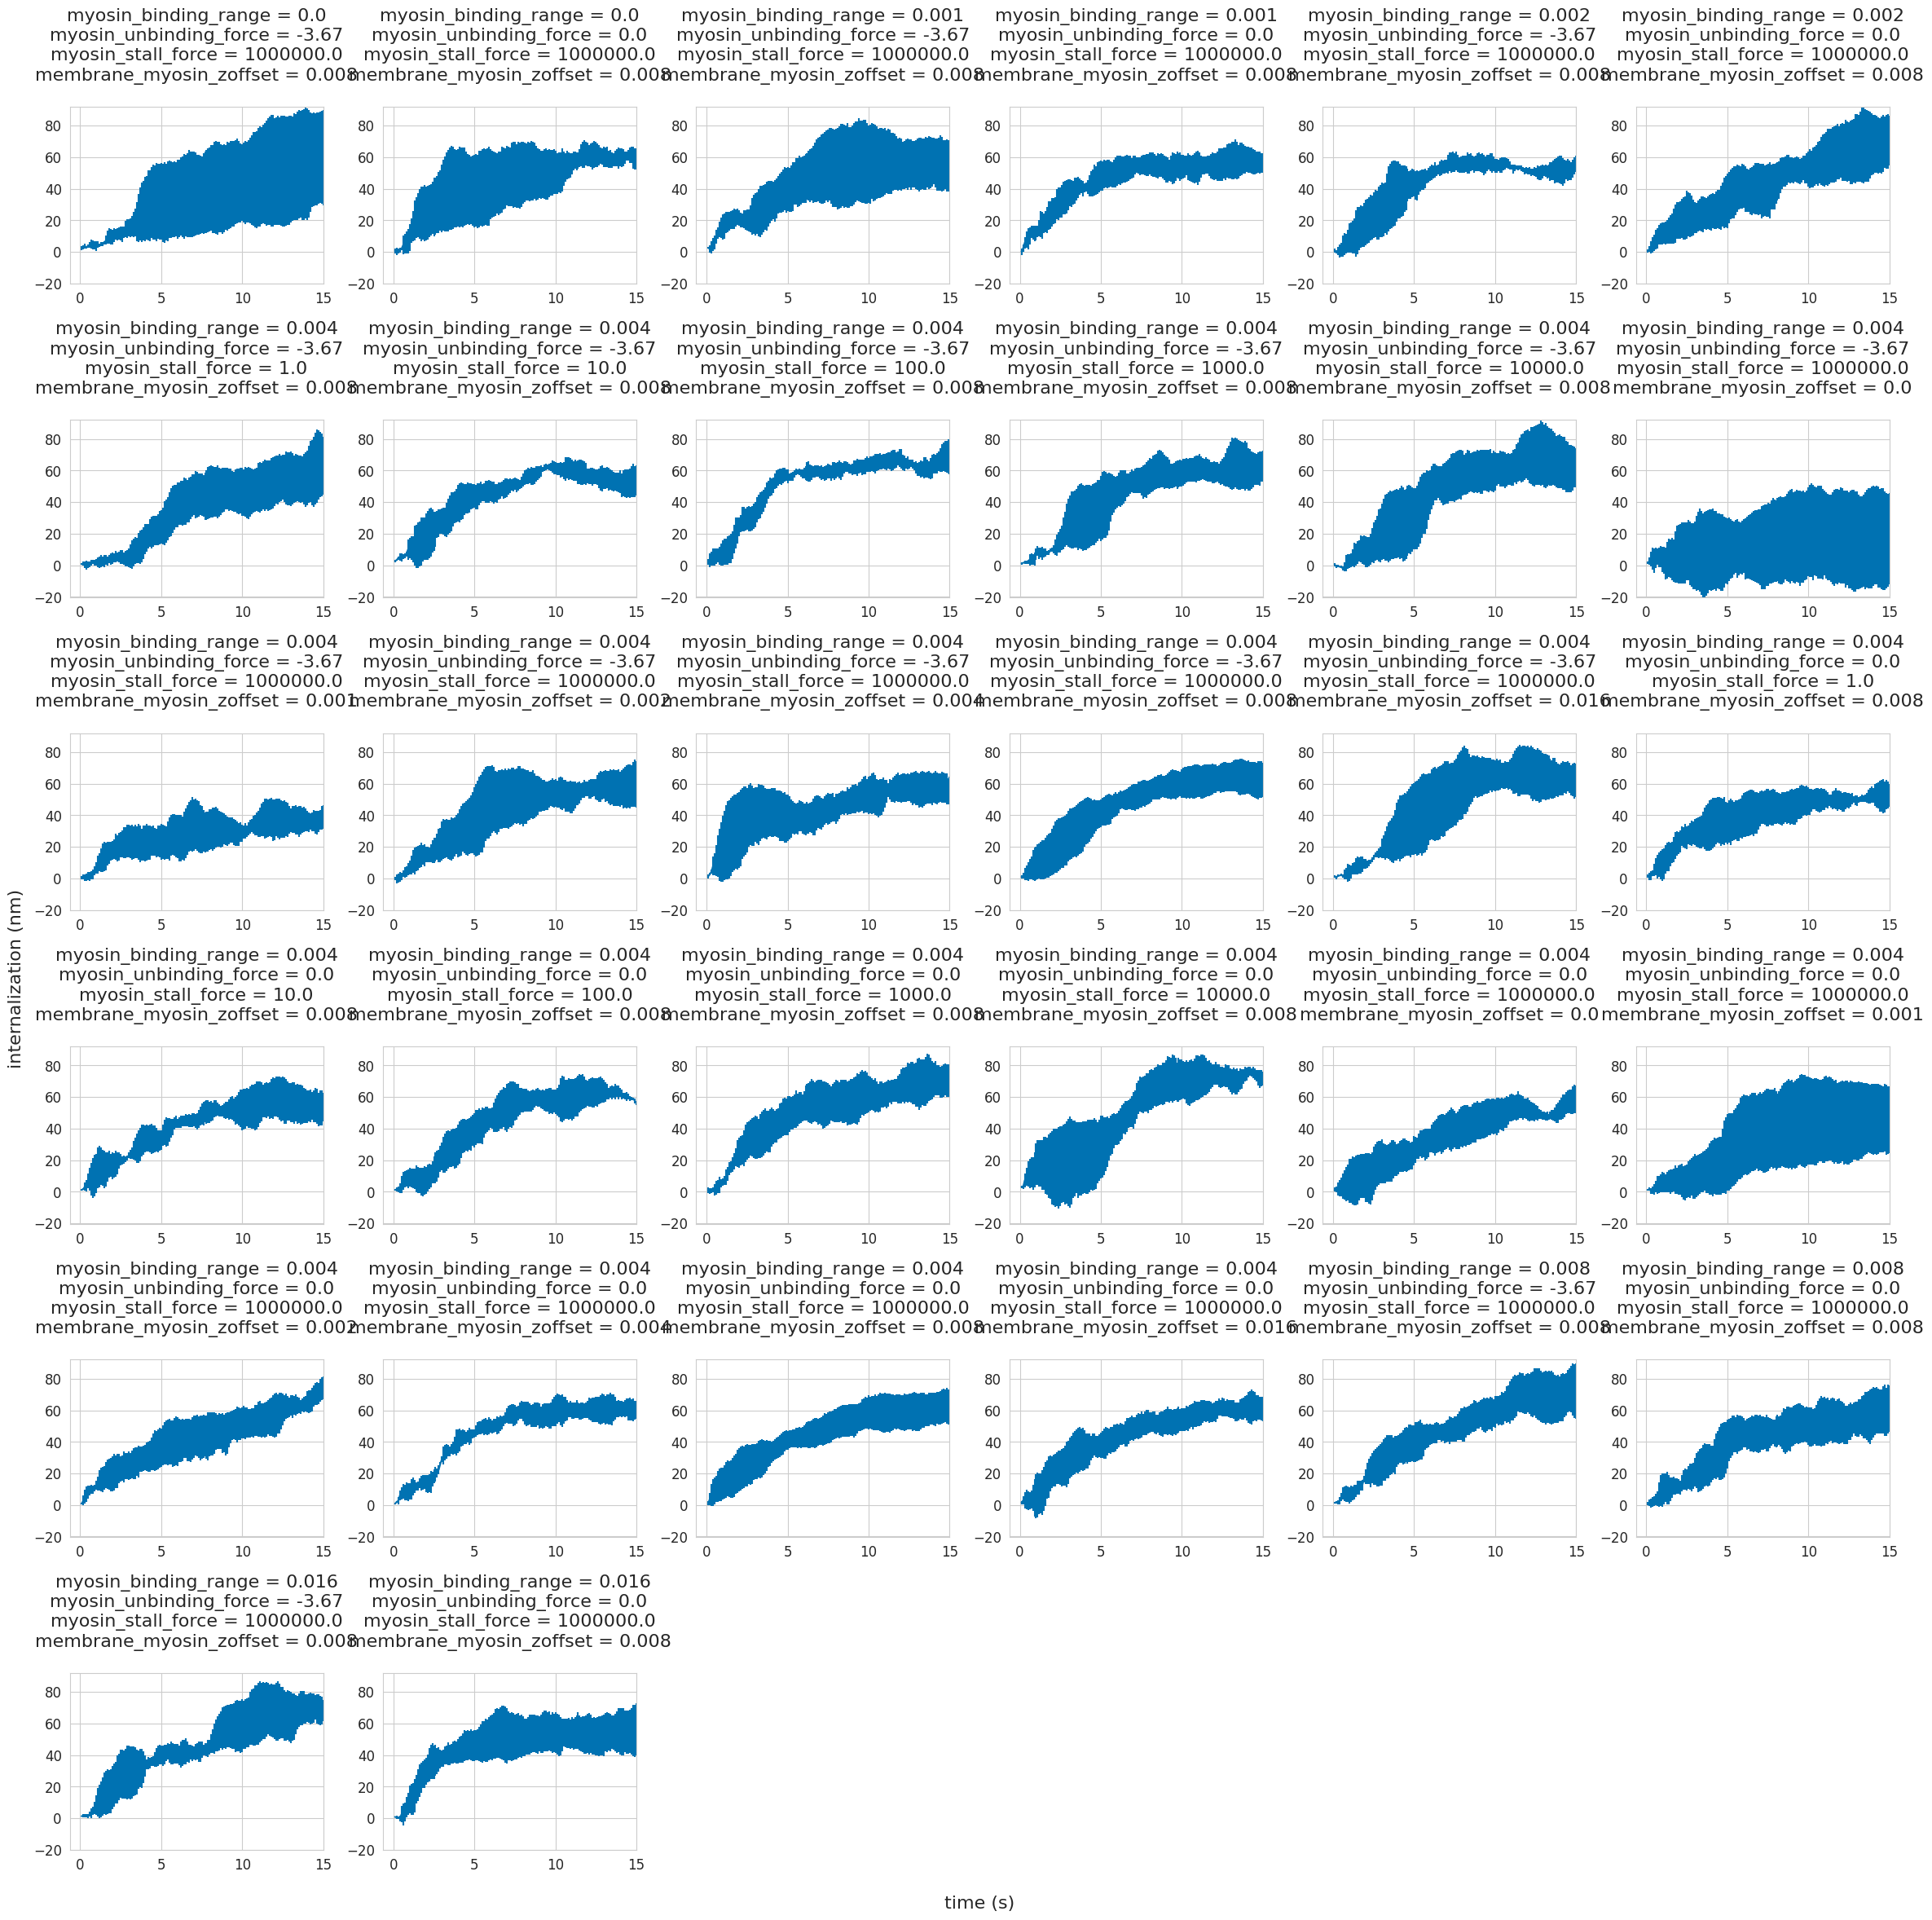

### means of individual parameter sweeps

``` python
for sweep in output_dirs:
    sweep_config = config_unique.loc[sweep]
    sweep_config_nunique = sweep_config.apply(pd.Series.nunique)
    cols_to_drop = sweep_config_nunique[sweep_config_nunique == 1].index
    sweep_config_unique = sweep_config.drop(cols_to_drop, axis = 1)

    sweep_plots = []
    for name, group in solid_sweep_groups:
        if sweep in name:
            sweep_plots.append(name)

    num_plots = len(sweep_plots)

    width = 6
    if width > num_plots:
        width = num_plots
    if num_plots == 24:
        width = 5
    height = int(math.ceil(float(num_plots)/float(width)))

    fig = plt.figure()
    fig.set_size_inches(4*width,4*height)
    # if height == 1:
    #     fig.set_size_inches(4*width,6*height)
    # else:
    #     fig.set_size_inches(4*width,5*height)
    fig.suptitle(sweep)

    commonaxis = plt.axes(frameon=False)
    commonaxis.set_xticks([])
    commonaxis.set_yticks([])
    commonaxis.yaxis.labelpad = 40 # move the labels a bit away from panels
    commonaxis.xaxis.labelpad = 60 # move the labels a bit away from panels
    commonaxis.set( xlabel = 'time (s)' )
    commonaxis.set( ylabel = 'internalization (nm)' )

    plot_no = 1
    plot_max = np.max(sweep_means + sweep_stds)*1000
    plot_min = np.min(sweep_means - sweep_stds)*1000

    for name in sweep_plots:
        x = sweep_means.loc[name].reset_index()['time']
        y = sweep_means.loc[name]*1000
        std = sweep_stds.loc[name]*1000

        ax = fig.add_subplot(height, width, plot_no)
        ax.errorbar(x,y,std)
        ax.set_xlim(right = 15)
        ax.set_ylim(bottom = plot_min, top = plot_max)

        title = ''
        for prop, value in zip(config_groups, name):
            addition = prop + ' = ' + str(round(value,3)) + '\n'
            if prop in list(sweep_config_unique):
                title += addition


        ax.set_title(title)

        print(plot_no)

        plot_no += 1

    pad = 0.9 + (float(height)/100.)
    fig.tight_layout(rect=[0, 0, 1, pad])

    if save_figures == 'yes':
        plt.savefig(working_dir+'figures/'+pref+'_'+sweep+'_mean_solid_zpos-vs-time.png')
```

``` example
1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12
```

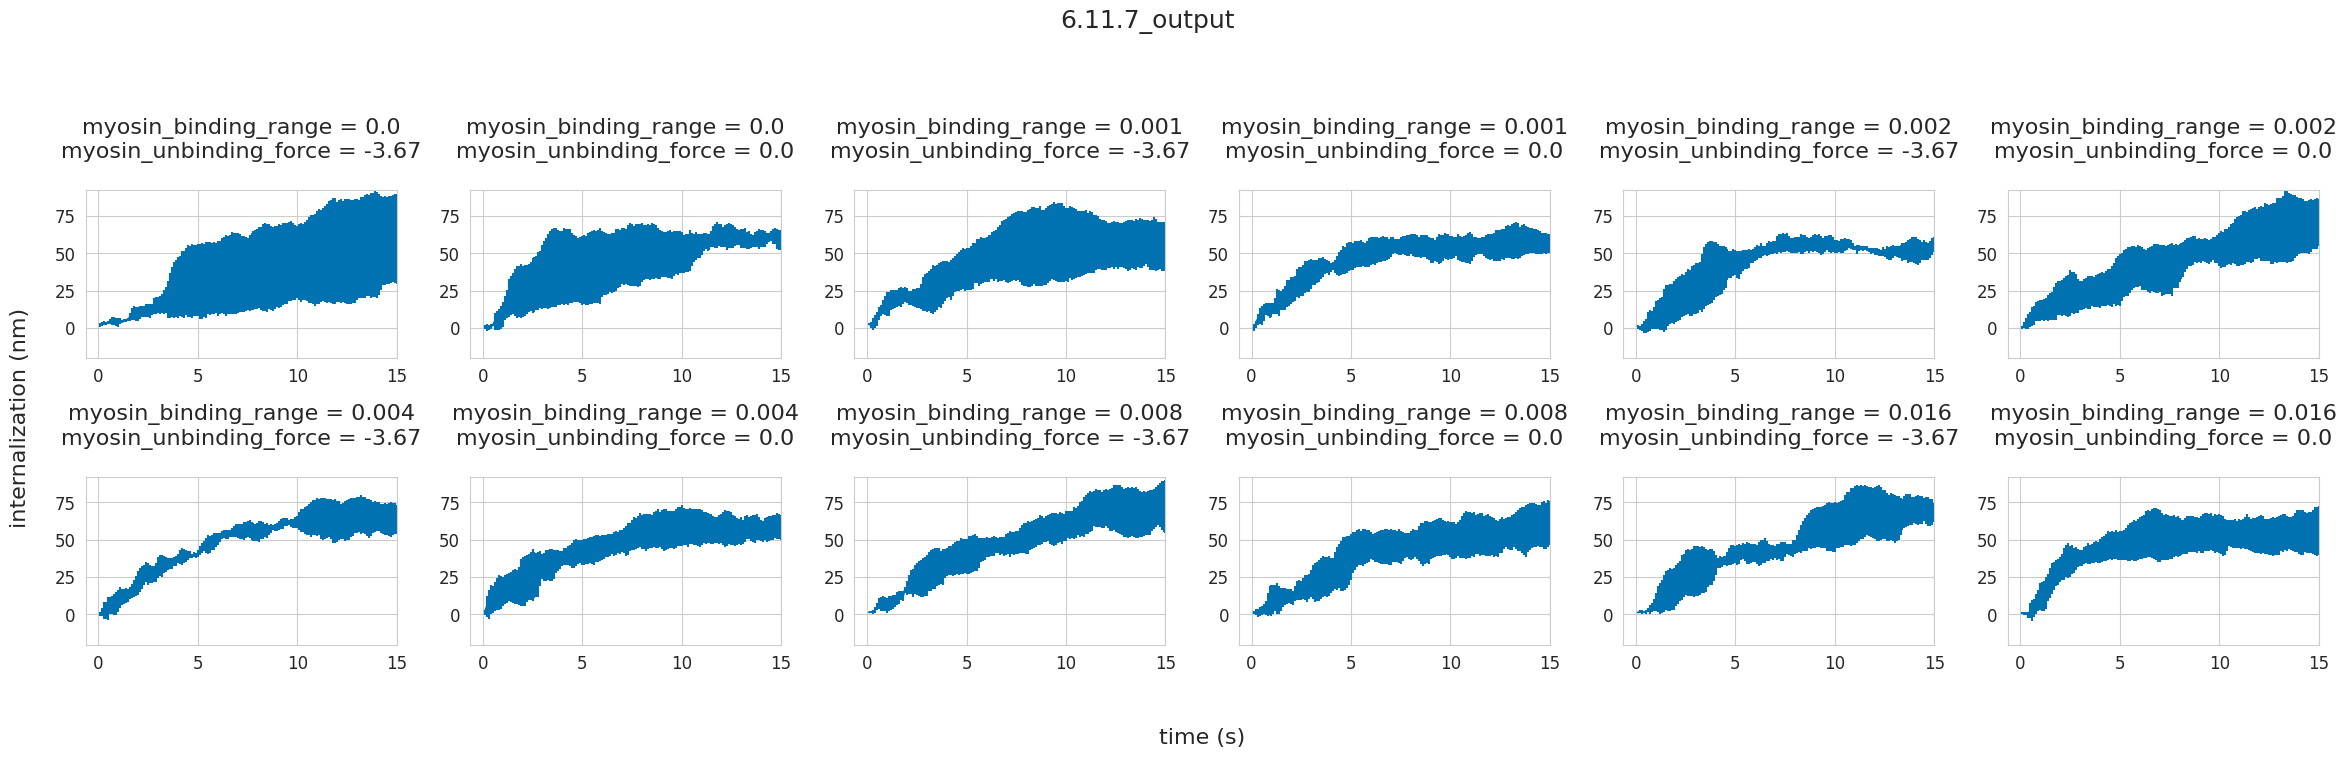
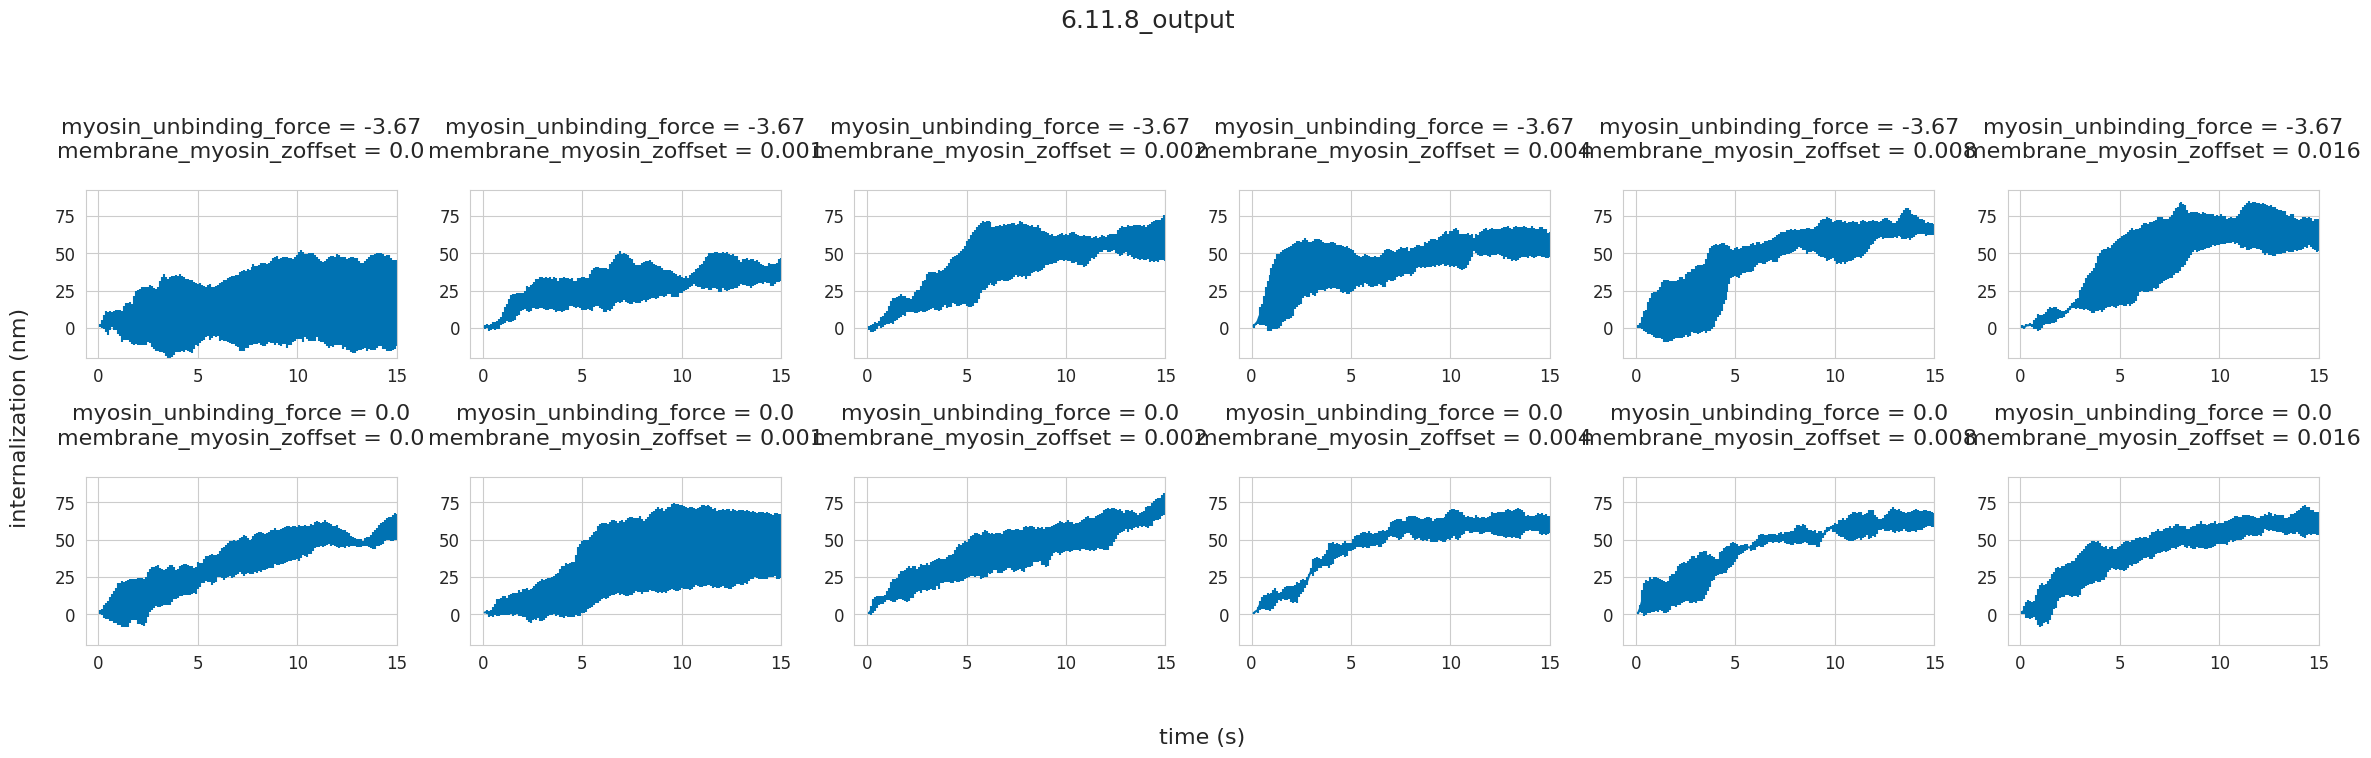
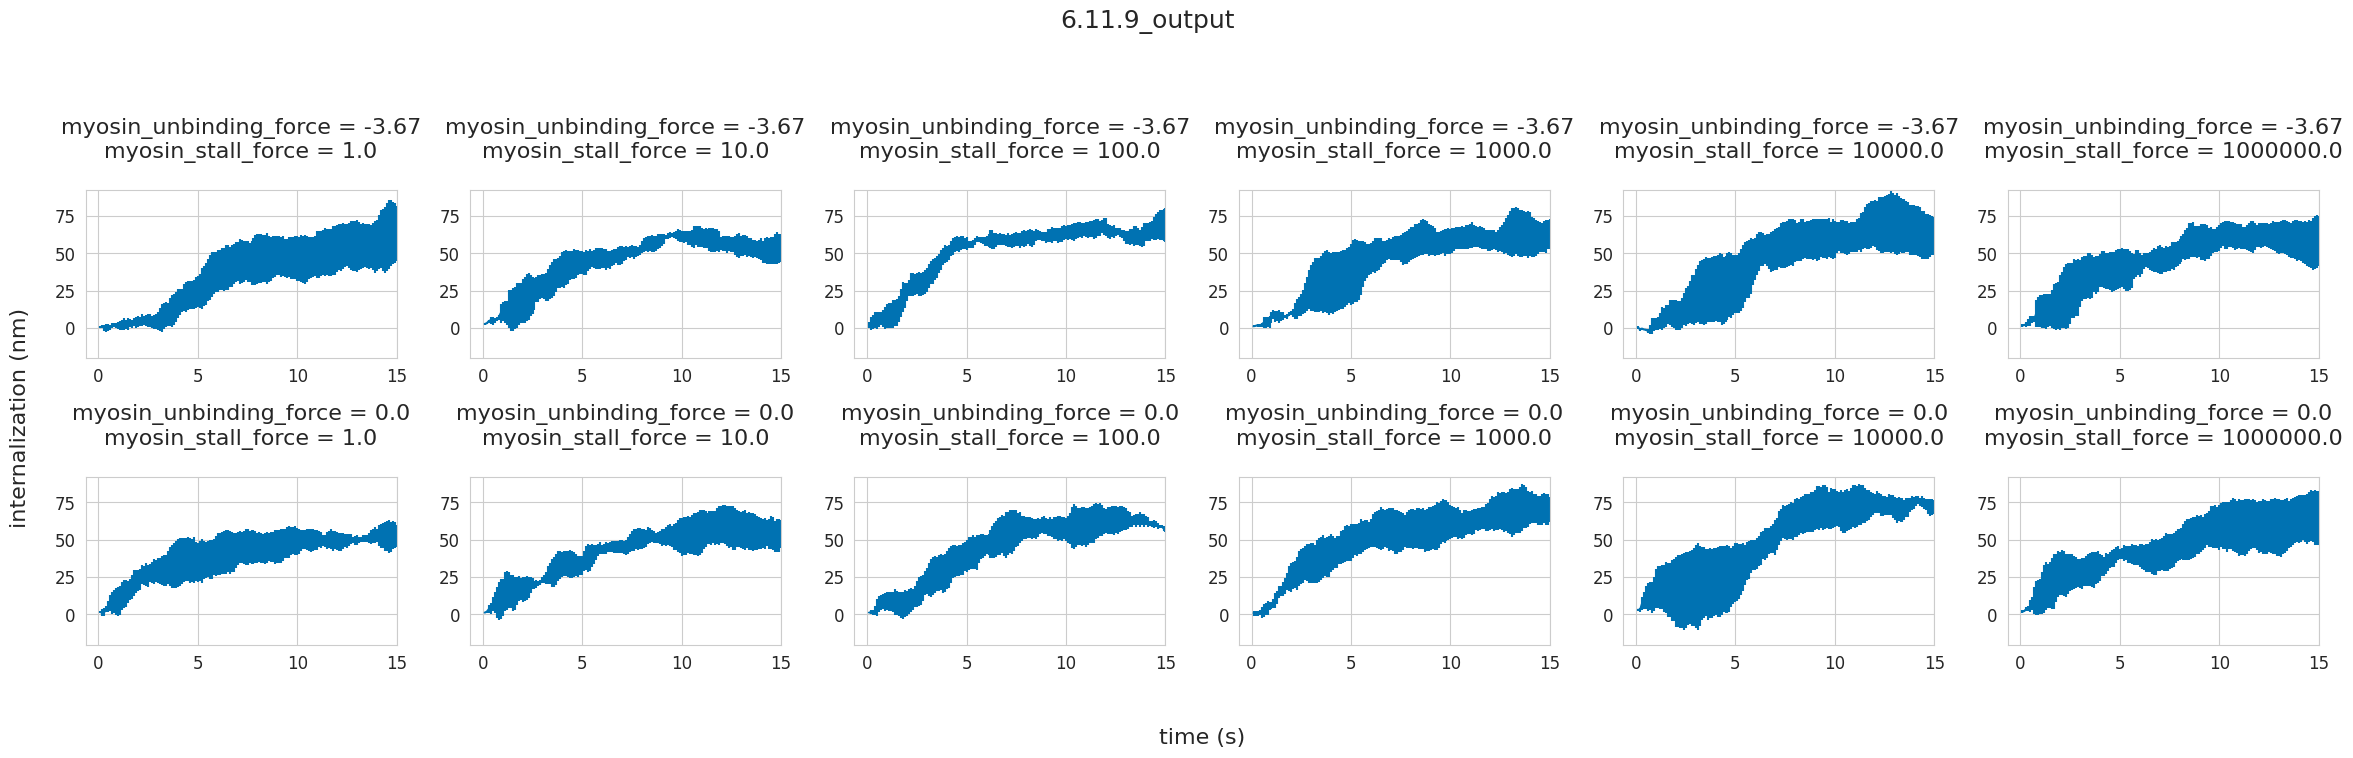

## cumulative histogram

plot an example internalization and cumulative histogram

``` python
internalization = solid_allparams.loc[output_dir].loc[run]['internalization']*1000
y = internalization
x = internalization.reset_index()['time']
plt.plot(x,y)
plt.xlabel('time (s)')
plt.ylabel('internalization (nm)')

plt.tight_layout()

if save_figures == 'yes':
  plt.savefig(working_dir+'figures/'+pref+'_solid_internalization_example.png')
```

``` python
plt.hist(internalization, 50, cumulative=True, density=True, histtype='step')
percentile = np.percentile(internalization, 95)
plt.plot([percentile, percentile], [0,1], label='95th percentile')
plt.ylabel('cumulative density')
plt.xlabel('internalization (nm)')
plt.legend()

plt.tight_layout()

if save_figures == 'yes':
  plt.savefig(working_dir+'figures/'+pref+'_solid_cumhist_percentile_example.png')
```

plot all cumulative histograms with 95 percentile internalization marked

``` python
num_plots = total_runs

width = 6
height = num_plots//width + 1

fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, figsize=(4*width,5*height))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
fig.text(0.5, 0, 'internalization (nm)', ha='center', size=24)
fig.text(0, 0.5, 'cumulative density', va='center', rotation='vertical', size=24)

plot_no = 0

for output_dir in output_dirs:
    rundirs = rundirs_allparams_df.loc[output_dir]
    for run in rundirs:
        if run == 'empty':
            continue
        internalization = solid_allparams.loc[output_dir].loc[run]['internalization']*1000
        props = properties_allparams.loc[output_dir].loc[run]
        viscosity = props['internalize.cym_viscosity']
        hip1r_off = props['strongbinder_unbinding'].split(',')[0]

        plot_no += 1

        plt.subplot(height,width,plot_no) #height, width
        plt.hist(internalization, 50, cumulative=True, density=True, histtype='step')
        percentile = np.percentile(internalization, 95)
        plt.plot([percentile, percentile], [0,1])
        plt.xlim(right = 100)
        #plt.ylim(top = 100)

        title = output_dir+'\n'+run+'\n'
        for prop in property_groups:
            title += prop + ' = ' + str(props[prop]) + '\n'

        plt.title(title)

plt.tight_layout()

if save_figures == 'yes':
  plt.savefig(working_dir+'figures/'+pref+'_solid_cumhist_percentile_all.png')

```

## plot 95th percentile internalization vs. parameter sweeps

``` python
percentiles_config = pd.concat([config_unique, percentiles],axis=1)
percentiles_config.head()
```

``` python
percentiles_props = pd.concat([properties_unique, percentiles],axis=1)
percentiles_props.head()
```

``` python
plt.scatter(percentiles_props['bud_confine'], percentiles_props['95_percentile_internalization'])
```

``` example
<matplotlib.collections.PathCollection at 0x1377867d0>
```

``` python
percentiles_props.loc[percentiles_props['membrane_myosin_number']==0].mean()
```

### scatterplot overlaid points

``` python
percentiles_props['myosin_unbinding'].fillna(value='empty', inplace=True)
x = []
y = []
z = []
for output_dir in output_dirs:
    rundirs = rundirs_allparams_df.loc[output_dir]
    for run in rundirs:
        if run == 'empty':
            continue
        myosin_unbinding = percentiles_props.loc[output_dir].loc[run]['myosin_unbinding']
        if myosin_unbinding == 'empty':
            continue
        myosin_off = float(myosin_unbinding.split(',')[0])
        myosin_catch = float(myosin_unbinding.split(',')[1])
        percentile = percentiles_props.loc[output_dir].loc[run]['95_percentile_internalization']
        x.append(myosin_off)
        y.append(myosin_catch)
        z.append(percentile)

plt.scatter(x,y,c=z,alpha=0.5,linewidths=10)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('off-rate')
plt.ylabel('catch bond')
plt.gray()
plt.colorbar()
plt.tight_layout()

if save_figures == 'yes':
  plt.savefig(working_dir+'figures/'+pref+'_95per_sweep_overlay.png')
```

### average scatterplot

``` python
# unbinding_groups = percentiles_props.groupby(['myosin_unbinding'])
unbinding_groups = percentiles_props.groupby(['myosin_unbinding','bud_confine'])
summary_percentiles = pd.concat([unbinding_groups['95_percentile_internalization'].mean(),
                                 unbinding_groups['95_percentile_internalization'].std()],
                                axis=1, keys = ['mean', 'std']).reset_index()
summary_percentiles = pd.concat([summary_percentiles['myosin_unbinding'].str.split(', ', expand = True),
                                 summary_percentiles], axis = 1)
summary_percentiles.columns = ['myo_off', 'myo_catch', 'myosin_unbinding', 'bud_confine',
                               'mean_95_percentile_internalization', 'std_95_percentile_internalization']
summary_percentiles = summary_percentiles[~summary_percentiles['myosin_unbinding'].str.contains('empty')]
```

1.  all

    ``` python
    x = pd.to_numeric(summary_percentiles['myo_off'])
    y = 1/pd.to_numeric(summary_percentiles['myo_catch'])
    y.replace([np.inf, -np.inf], 0, inplace=True)
    z = pd.to_numeric(summary_percentiles['mean_95_percentile_internalization'])

    plt.scatter(x,y,c=z,alpha=1,linewidths=10)
    plt.xscale('symlog', linthresh=0.1)
    plt.yscale('symlog', linthresh=0.001)
    plt.xlabel('myosin unbinding rate ($s^{-1}$)')
    plt.ylabel('inverse myosin unbinding force ($pN^{-1}$)')
    plt.plasma()
    plt.colorbar(label='mean 95 percentile internalization')
    plt.tight_layout()

    if save_figures == 'yes':
      plt.savefig(working_dir+'figures/'+pref+'_95per_sweep_means_scatter_inverse.png')
    ```

2.  split by resistance

    ``` python
    for bud_confine in properties_unique.bud_confine.unique():
      subset_percentiles = summary_percentiles[summary_percentiles['bud_confine']==bud_confine]
      x = pd.to_numeric(subset_percentiles['myo_off'])
      y = 1/pd.to_numeric(subset_percentiles['myo_catch'])
      y.replace([np.inf, -np.inf], 0, inplace=True)
      z = pd.to_numeric(subset_percentiles['mean_95_percentile_internalization'])

      plt.figure()
      plt.scatter(x,y,c=z,alpha=1,linewidths=10)
      plt.xscale('symlog', linthresh=0.1)
      plt.yscale('symlog', linthresh=0.001)
      plt.xlabel('myosin unbinding rate ($s^{-1}$)')
      plt.ylabel('inverse myosin unbinding force ($pN^{-1}$)')
      plt.plasma()
      plt.colorbar(label='mean 95 percentile internalization')
      plt.title('resistance = '+str(bud_confine))
      plt.tight_layout()

      if save_figures == 'yes':
        plt.savefig(working_dir+'figures/'+pref+'_95per_sweep_means_scatter_inverse_'+str(bud_confine)+'.png')
    ```

### line plots

``` python
xlabels = {
    'myosin_stall_force':'Myosin stall force ($pN$)',
    'membrane_myosin_zoffset':'Myosin z-offset\nfrom membrane ($\\mu m$)',
    'membrane_myosin_stiffness':'Myosin bond stiffness ($\\frac{pN}{\\mu m}$)',
    'myosin_binding_range':'Myosin binding range ($\mu m$)'
}

to_plot = [
 '6.11.9_output',
 '6.11.8_output',
 '6.11.4_output',
 '6.11.7_output'
 ]

for sweep in to_plot:
    percentiles_config_sweep = percentiles_config.loc[sweep]
    sweep_config_nunique = percentiles_config_sweep.apply(pd.Series.nunique)
    cols_to_drop = sweep_config_nunique[sweep_config_nunique == 1].index
    percentiles_sweep_unique = percentiles_config_sweep.drop(cols_to_drop, axis=1)

    sweep_config = config_unique.loc[sweep]
    sweep_config_nunique = sweep_config.apply(pd.Series.nunique)
    cols_to_drop = sweep_config_nunique[sweep_config_nunique == 1].index
    sweep_config_unique = sweep_config.drop(cols_to_drop, axis=1)

    percentiles_sweep_groups = percentiles_sweep_unique.groupby(list(sweep_config_unique.columns))
    summary_percentiles_sweep = pd.concat([percentiles_sweep_groups['95_percentile_internalization'].mean(),
                                           percentiles_sweep_groups['95_percentile_internalization'].std()],
                                          axis=1, keys=['mean', 'std']).reset_index()

    neutral_bond = summary_percentiles_sweep.loc[summary_percentiles_sweep['myosin_unbinding_force'] == 0]
    slip_bond = summary_percentiles_sweep.loc[summary_percentiles_sweep['myosin_unbinding_force'] == 1000]
    catch_bond = summary_percentiles_sweep.loc[summary_percentiles_sweep['myosin_unbinding_force'] == -3.67]
    xcol = summary_percentiles_sweep.drop(['myosin_unbinding_force', 'mean', 'std'], axis=1).columns[0]

    fig, ax = plt.subplots(figsize=[7, 6])

    if neutral_bond.shape[0] > 0:
        ax.plot(neutral_bond[xcol], neutral_bond['mean'], label='Force-insensitive', color='tab:blue')
        ax.fill_between(neutral_bond[xcol], neutral_bond['mean'] - neutral_bond['std'], neutral_bond['mean'] + neutral_bond['std'],
                    color='tab:blue', alpha=0.3)

    if slip_bond.shape[0] > 0:
        ax.plot(slip_bond[xcol], slip_bond['mean'], label='Force-insensitive', color='tab:blue')
        ax.fill_between(slip_bond[xcol], slip_bond['mean'] - slip_bond['std'], slip_bond['mean'] + slip_bond['std'],
                        color='tab:blue', alpha=0.3)

    if catch_bond.shape[0] > 0:
        ax.plot(catch_bond[xcol], catch_bond['mean'], label='Myo5 force sensitivity', color='tab:orange')
        ax.fill_between(catch_bond[xcol], catch_bond['mean'] - catch_bond['std'], catch_bond['mean'] + catch_bond['std'],
                        color='tab:orange', alpha=0.3)

    ax.set_xscale('log', base=10)
    ax.set_xlabel(xlabels[xcol])
    ax.set_ylabel('Mean 95 percentile\ninternalization ($nm$)')
    ax.legend()
    plt.tight_layout()

    if save_figures == 'yes':
        plt.savefig(working_dir + 'figures/publish/' + sweep + '_95per_means_std_lines.svg')

```